### Run notebook in parts in conjuction with others

In [1]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

In [2]:
from lib import utils
from lib.metrics import masked_rmse_np, masked_mape_np, masked_mae_np
from lib.utils import StandardScaler

### Still at inference time, we need ground truths and inputs in chunks
### I should devise my own method of doing it in chunks data, from the sensor volume

- But, I should split into only 2 sets by keeping the test same

In [3]:
def historical_average_new(train_inputs, train_gts, test, period):
    
    num_periods = int(len(train_gts)/period)
    #num_periods=4
    print("Periods:", num_periods)
    test_preds=[]
    for i in range(len(test)):
        test_period_preds=[]
        for multiplier in range(1,num_periods+1):
            period_index = multiplier*period-i # for 1st just go period - i
            test_period_preds.append(train_gts[-period_index])
        #print("NM",test_period_preds)
        test_period_preds = np.mean(np.array(test_period_preds), axis=0)
        #print("M",test_period_preds)
        test_preds.append(test_period_preds)
        
    test_preds = np.array(test_preds)
    print(test_preds.shape)
    
    return test_preds

In [4]:
# CONSTANTS
TEST_RATIO = 0.2
PERIOD = 7 * 24 * 12 # Total number of hours in a week # 2016
NULL_VALUE = 0.

In [5]:
# The data is sensor_volume_150.csv
data = pd.read_csv('./data/sensor_volume_150.csv')

n_sample, n_sensor = data.shape
print(f"Total Samples: {n_sample}, Total Sensors: {n_sensor}")

n_test = int(round(n_sample * TEST_RATIO))
print(f"\nTest Samples: {n_test}")

n_train = n_sample - n_test
print(f"\nTrain Samples: {n_train}")

Total Samples: 13104, Total Sensors: 150

Test Samples: 2621

Train Samples: 10483


In [6]:
data.head()

,715898,715918,715920,715929,715930,715933,715938,715944,715947,715996,...,716788,716797,716800,716810,716819,716829,716834,716841,716847,716857
0,887,1045.0,2931.0,3303,3067,2763.0,2994,2622.0,2909,2958,...,1409.0,1178,1180.0,3257.0,1180.0,2365,3029.0,1636,531.0,1182.0
1,561,687.0,4558.0,5058,4559,3944.0,4417,3952.0,4274,3893,...,931.0,774,773.0,4708.0,773.0,3146,4026.0,2518,337.0,774.0
2,483,543.0,3167.0,3527,3470,3158.0,3452,3119.0,3039,2846,...,927.0,656,656.0,3440.0,656.0,2277,2924.0,1587,287.0,657.0
3,531,589.0,2126.0,2255,1808,1642.0,1834,1697.0,1892,1715,...,1284.0,742,740.0,2475.0,740.0,1568,2020.0,1038,328.0,741.0
4,1088,1263.0,1452.0,1284,1336,1270.0,1428,1307.0,1133,1196,...,2715.0,1588,1588.0,2026.0,1588.0,1368,1761.0,884,691.0,1587.0


In [7]:
data_val = data.values

In [8]:
# Chunk the whole data first, chunking  itself will reduce the total length by 24 (because each chunk has size 12)
n_train = n_train -12
n_test = n_test -12

inputs = []
for i in range(data_val.shape[0] - 24):
    each_chunk=[]
    for j in range(12):
        each_chunk.append(data_val[i+j])
    inputs.append(each_chunk)
inputs = np.array(inputs)
print(inputs.shape)

gts = []
for i in range(12, data_val.shape[0]-12):
    each_chunk=[]
    for j in range(12):
        each_chunk.append(data_val[i+j])
    gts.append(each_chunk)
gts = np.array(gts)
print(gts.shape)

# Then separate into inputs and gts
train_inputs_orig = inputs[:n_train]
train_gts_orig = gts[:n_train]

# test and train should have continous hours for period to work

test_inputs=inputs[-n_test:]
test_gts=gts[-n_test:]

print("Train: inputs {}, gts{}".format(train_inputs_orig.shape, train_gts_orig.shape))
print("Test: inputs {}, gts{}".format(test_inputs.shape, test_gts.shape))

(13080, 12, 150)
(13080, 12, 150)
Train: inputs (10471, 12, 150), gts(10471, 12, 150)
Test: inputs (2609, 12, 150), gts(2609, 12, 150)


### Why are periodic data shockingly similar?
    - Only for a few sensors. eg. sensor 0,1

25
[1044. 1000. 1462. 3570. 6928. 6464. 7041. 7054. 6800. 5806. 6651. 6269.]
[6130. 6532. 6545. 6284. 5653. 5795. 5187. 4822. 4497. 3899. 2553. 1314.]


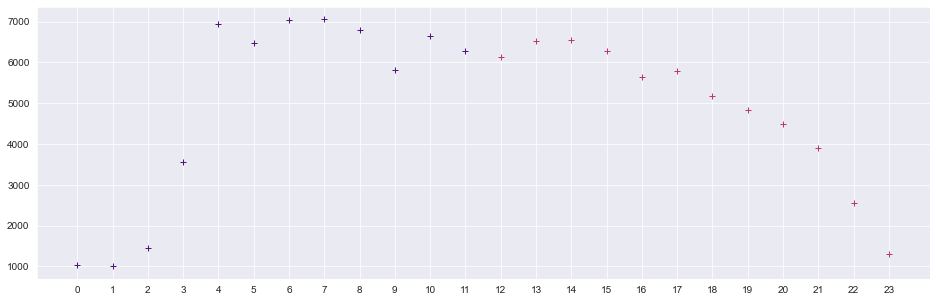

In [9]:
# verify inputs and gts
# train
data_select=25
print(data_select)

x_total = np.arange(0,24)
x_input = np.arange(0,12)
x_gt = np.arange(12,24)

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(x_input,train_inputs_orig[data_select,:,4], '+')
plt.plot(x_gt,train_gts_orig[data_select,:,4], '+')
plt.xticks(x_total);

print(train_inputs_orig[data_select,:,4])
print(train_gts_orig[data_select,:,4])

6073
[1165. 1137. 1689. 3884. 7343. 6802. 6727. 6970. 6967. 6383. 6380. 6006.]
[6273. 6067. 6028. 6090. 6138. 6018. 5902. 5411. 4680. 4182. 2210. 1571.]


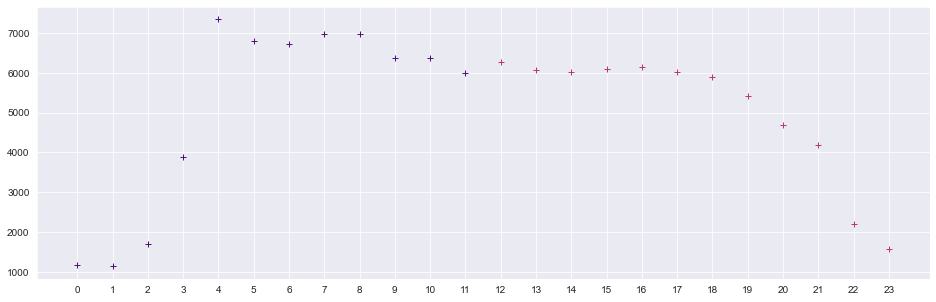

In [10]:
ds = data_select+3*PERIOD
print(ds)

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(x_input,train_inputs_orig[ds,:,4], '+')
plt.plot(x_gt,train_gts_orig[ds,:,4], '+')
plt.xticks(x_total);

print(train_inputs_orig[ds,:,4])
print(train_gts_orig[ds,:,4])

25
[1397. 1369. 1563. 1969. 2045. 2199. 2175. 2195. 1886. 1819. 1679. 1743.]


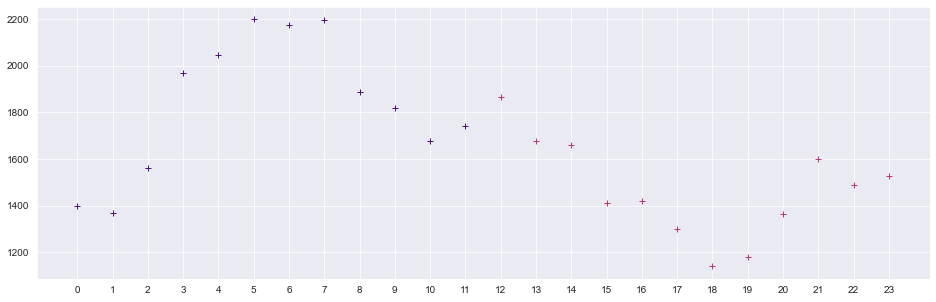

In [11]:
# verify inputs and gts
# test
print(data_select)

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(x_input,test_inputs[data_select,:,14], '+')
plt.plot(x_gt,test_gts[data_select,:,14], '+')
plt.xticks(x_total);

print(test_inputs[data_select,:,14])

2041
[1312. 1540. 2208. 2687. 2610. 2836. 2697. 2459. 2265. 1988. 1895. 1889.]


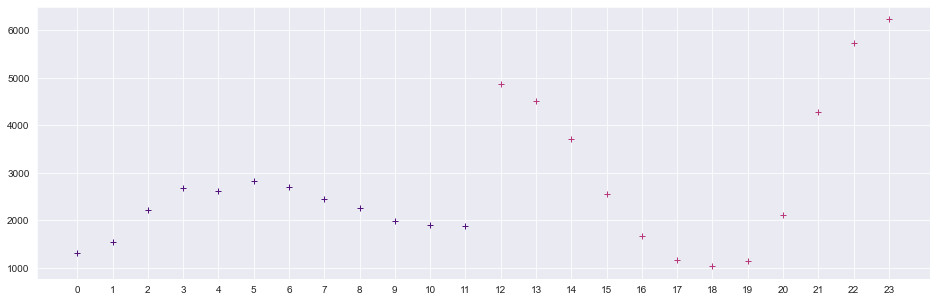

In [12]:
ds = data_select+1*PERIOD
print(ds)

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(x_input,test_inputs[ds,:,14], '+')
plt.plot(x_gt,test_gts[ds,:,1], '+')
plt.xticks(x_total);

print(test_inputs[ds,:,14])

In [13]:
preds = historical_average_new(train_inputs_orig, train_gts_orig, test_inputs, PERIOD)

Periods: 5
(2609, 12, 150)


In [14]:
np.save('./ha/test_inputs.npy', test_inputs)
np.save('./ha/test_preds.npy', preds)
np.save('./ha/test_gts.npy', test_gts)

125
[3241. 3954. 4819. 7257. 7647. 6792. 6573. 7414. 7336. 7129. 6806. 6728.]
[6845. 5166. 5890. 5190. 5491. 5994. 5341. 3309. 2215. 1514. 1076. 1031.]


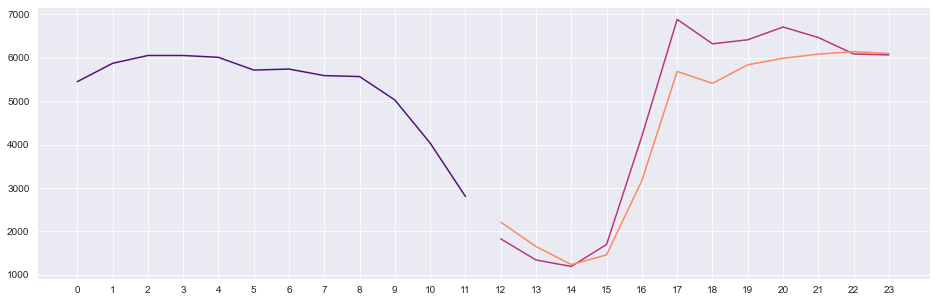

In [15]:
# verification
data_select=125
print(data_select)

x_total = np.arange(0,24)
x_input = np.arange(0,12)
x_gt = np.arange(12,24)

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(x_input,test_inputs[data_select,:,4]) #blue
plt.plot(x_gt,test_gts[data_select,:,4]) #orange
plt.plot(x_gt,preds[data_select,:,4]) #green
plt.xticks(x_total);

print(train_inputs_orig[data_select,:,4])
print(train_gts_orig[data_select,:,4])

In [16]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [17]:
print(preds.shape)
print(test_gts.shape)
rmse_orig, rmse_orig_collect = get_metrics(preds, test_gts)

(2609, 12, 150)
(2609, 12, 150)


In [18]:
rmse_orig

935.4561629440346

### Wow, HA is fairly accurate
- But how to get HA for training data (to train CNN)
- just pass the train data as test? - doesnt work - because the continuity of time is broken
- For training data, for each data point, take average among the data
- Training data is just for one period.. makes sense

In [19]:
#10471

def historical_avg_training(train_set, train_gts, period):
    train_preds =[]

    # How many total periods are there?
    num_periods = int(len(train_gts)/period)
    # we are only going to do for one period, because all will repeat after that
    
    #print(num_periods)
    for i in range(period):
        train_preds_period=[]
        for multiplier in range(num_periods): # range from 0 is correct
            period_index = multiplier*period + i #for first just go i
            #print(period_index)
            train_preds_period.append(train_gts[period_index])
            #print(train_gts[period_index])
        train_preds_period = np.mean(np.array(train_preds_period), axis=0)
        train_preds.append(train_preds_period)
        
    train_preds = np.array(train_preds)
    print(train_preds.shape)
    #train_preds = np.repeat(train_preds,2, axis=0)
    print(train_preds.shape)
    
    return train_preds

In [20]:
train_preds = historical_avg_training(train_inputs_orig, train_gts_orig, PERIOD)

(2016, 12, 150)
(2016, 12, 150)


In [21]:
train_inputs = train_inputs_orig[0:train_preds.shape[0]]
print(train_inputs.shape)

(2016, 12, 150)


In [22]:
train_gts = train_gts_orig[0:train_preds.shape[0]]
print(train_gts.shape)

(2016, 12, 150)


In [23]:
# train new cnn on these input, pred combination

In [24]:
rmse_train, rmse_train_collect = get_metrics(train_preds, train_gts)
print(rmse_train)

596.5507291143908


In [25]:
np.save('./ha/train_inputs.npy', train_inputs)
np.save('./ha/train_preds.npy', train_preds)
np.save('./ha/train_gts.npy', train_gts)

### Run After AEs

In [26]:
# get scalers
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [27]:
# FGSM
# Adversarial inputs on test set
adv_flow = np.load('./ha/adv_fgsm.npy', allow_pickle = True)
print(f'Adv Inpts: shape= {adv_flow.shape}, Max = {np.max(adv_flow)}')

# They all need to be denormalized
adv_flow = adv_flow*std + mean
print(f'\nInputs: shape= {adv_flow.shape}, Max = {np.max(adv_flow)}')

gts = np.load('./ha/test_gts.npy', allow_pickle = True)
print(f'GTs: shape= {gts.shape}, Max = {np.max(gts)}')

Adv Inpts: shape= (2609, 12, 150), Max = 3.490483283996582

Inputs: shape= (2609, 12, 150), Max = 11644.0
GTs: shape= (2609, 12, 150), Max = 11644.0


In [28]:
# Make predictions on the adversarial inputs
fgsm_preds = historical_average_new(train_inputs_orig, train_gts_orig, adv_flow, PERIOD)

Periods: 5
(2609, 12, 150)


In [29]:
rmse_fgsm, RMSE_collect_preds_on_fgsm = get_metrics(fgsm_preds, gts)

print("AEs: True RMSE: ", round(rmse_fgsm,2))

print("\nSignal wise collection: ")
print(f'Max ={np.max(RMSE_collect_preds_on_fgsm)}, Mean={round(np.mean(RMSE_collect_preds_on_fgsm),2)}, Shape={RMSE_collect_preds_on_fgsm.shape}')

AEs: True RMSE:  935.46

Signal wise collection: 
Max =1929.86, Mean=917.08, Shape=(2609,)


Text(0, 0.5, 'Number of signals')

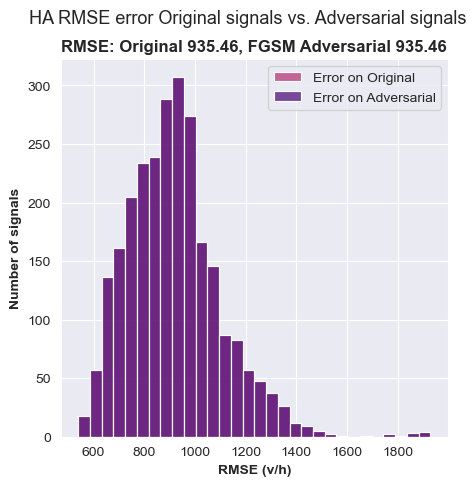

In [30]:
# RMSE Error distribution shift
#mean_rmse_inputs = np.mean(RMSE_collect_preds_on_inputs)
#mean_rmse_aes = np.mean(RMSE_collect_preds_on_aes)

labels =["Error on Original","Error on Adversarial"]
fig, axes =plt.subplots(figsize=(5,5),dpi=100)
fig.suptitle('HA RMSE error Original signals vs. Adversarial signals', fontsize=13)

rmse_plot = sns.histplot(data=[RMSE_collect_preds_on_fgsm, rmse_orig_collect], bins=30, kde=False, fill=True)
axes.set_title('RMSE: Original {}, FGSM Adversarial {}'.format(str(round(rmse_orig,2)), str(round(rmse_fgsm,2))), fontweight='bold')
axes.legend(labels)
axes.set_xlabel('RMSE (v/h)', fontweight='bold')
axes.set_ylabel('Number of signals', fontweight='bold')

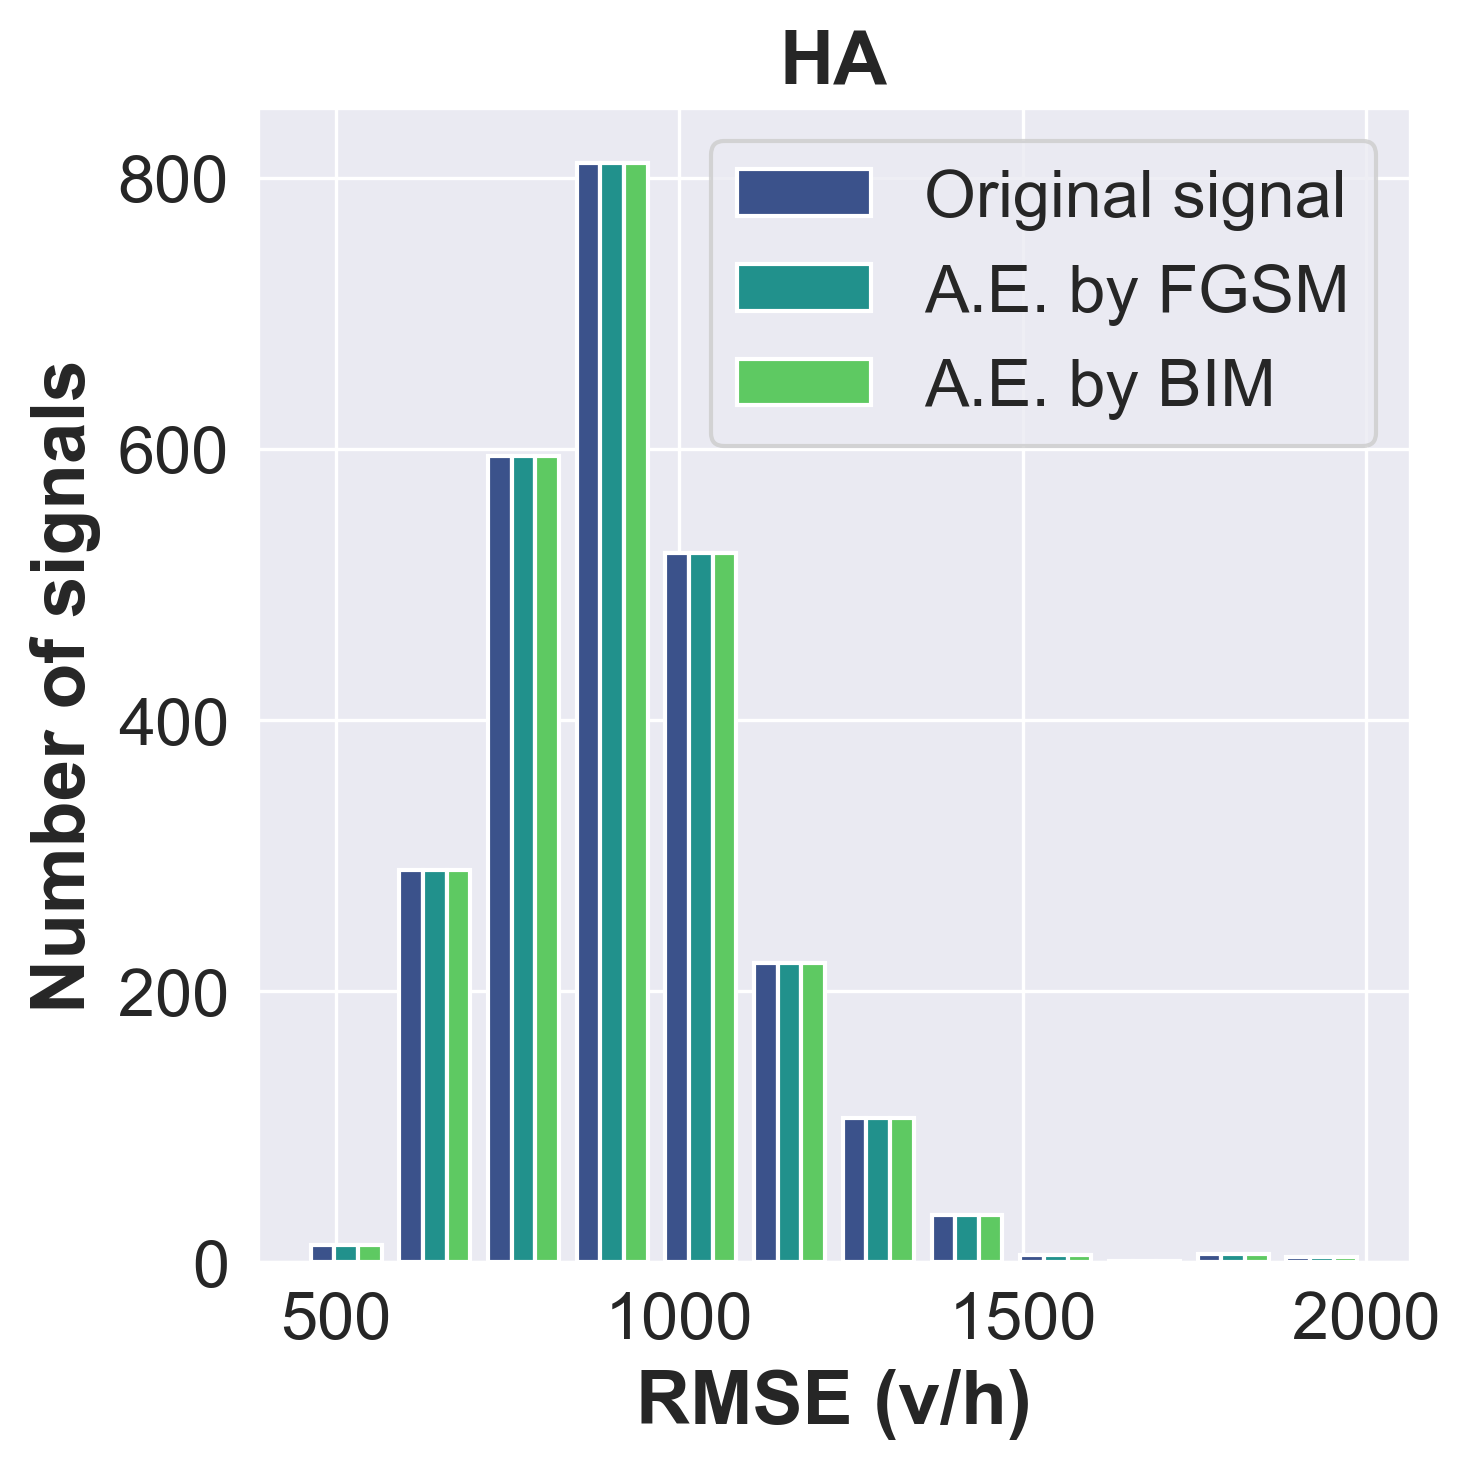

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

# Load inputs
orig_dstr = rmse_orig_collect
fgsm_dstr = RMSE_collect_preds_on_fgsm
bim_dstr = RMSE_collect_preds_on_fgsm

dstr_data = np.array([bim_dstr, fgsm_dstr, orig_dstr])
df = pd.DataFrame({'bim': dstr_data[2,:], 'fgsm': dstr_data[1,:], 'orig': dstr_data[0,:]})
df.shape


fs = 18

plt.rc('xtick', labelsize=fs-2) 
plt.rc('ytick', labelsize=fs-2) 

sns.set_palette(palette='viridis', n_colors=3)

n_bins = 12
x = df.values

fig, axes = plt.subplots(figsize=(5,5),dpi=300)
colors = df.columns
axes.hist(x, n_bins, density=False, histtype='bar', range=(450,2000), label=colors)

axes.set_title("HA", fontweight='bold',fontsize=fs)
labels =["Original signal","A.E. by FGSM","A.E. by BIM"]
axes.legend(labels, fontsize=fs-2)
axes.set_xlabel('RMSE (v/h)', fontweight='bold', fontsize=fs)
axes.set_ylabel('Number of signals', fontweight='bold', fontsize=fs);
fig.tight_layout()

### HA is immune to test time AEs because the predictions are based on historical dataa